# Exploratory Data Analysis (EDA)

In [ ]:
# import necesary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# import packages for GET requests
import requests
import time
import random

#Install geopandas to read in station geojson
!pip install geopandas
import geopandas as gpd

#Install holidays package to get federal Canadian holidays
!pip install holidays
import holidays

from sklearn.feature_selection import SelectKBest, f_classif

from google.colab import files

In [ ]:
#Define summary measure function
def mean_sd(df,col):
  print('\n'+col+':\n')
  print('Mean:',np.mean(df[col]))
  print('Std dev:',np.std(df[col]))

In [ ]:
#Note the original Excel file contains every year from 2010-2020. Only 2016 was used in order to be able to use the 2016 census data. This sheet selection was done in Excel because of the max limit on file size in Google Sheets
paramedicsdf = pd.read_csv('https://docs.google.com/spreadsheets/d/1VoqICOJiG-t_qeqYLh3gqIr9RRh68N3CUvUsIlIrhTE/export?format=csv')
paramedicsdf.head()

,ID,Dispatch_Time,Incident_Type,Priority_Number,Units_Arrived_At_Scene,Forward_Sortation_Area
0,4991156,2016-01-01 0:05,Medical,4,1,M9W
1,4991157,2016-01-01 0:05,Medical,1,1,M2J
2,4991158,2016-01-01 0:06,Medical,1,1,M3N
3,4991159,2016-01-01 0:07,Medical,1,1,M4G
4,4991160,2016-01-01 0:08,Medical,4,2,M5H


In [ ]:
print(paramedicsdf.shape)

(266350, 6)


In [ ]:
print('NaN by column for the paramedic data:\n',paramedicsdf.isna().sum())
#All of the NaNs are in the FSA column; remove them because they cannot be imputed
paramedicsdf = paramedicsdf[~paramedicsdf['Forward_Sortation_Area'].isna()].reset_index(drop=True)

#NEW: Drop priority number to simplify analysis and units arrived at scene
paramedicsdf.drop(columns=['Priority_Number','Units_Arrived_At_Scene'],inplace=True)

paramedicsdf.head()


NaN by column for the paramedic data:
 ID                         0
Dispatch_Time              0
Incident_Type              0
Priority_Number            0
Units_Arrived_At_Scene     0
Forward_Sortation_Area    50
dtype: int64


,ID,Dispatch_Time,Incident_Type,Forward_Sortation_Area
0,4991156,2016-01-01 0:05,Medical,M9W
1,4991157,2016-01-01 0:05,Medical,M2J
2,4991158,2016-01-01 0:06,Medical,M3N
3,4991159,2016-01-01 0:07,Medical,M4G
4,4991160,2016-01-01 0:08,Medical,M5H


In [ ]:
# priority_breakdown = paramedicsdf['Priority_Number'].value_counts()
# priority_breakdown

In [ ]:
#Remove priorities 11,12,13 because their definitions could not be found
#Map values 9:1, 1:2, 3:3, 4:4, 5:5 based on research where 1 is the highest priority response and 5 is the lowest priority response

# paramedicsdf = paramedicsdf[~paramedicsdf['Priority_Number'].isin([11,12,13])].reset_index(drop=True)
# paramedicsdf['Priority_Number'] = paramedicsdf['Priority_Number'].map({9:1,1:2,3:3,4:4,5:5})
# paramedicsdf.head()

In [ ]:
#TODO: Should incident type be removed?
paramedicsdf['Incident_Type'].value_counts()

Medical                   247082
Motor Vehicle Accident     13011
Emergency Transfer          5211
Fire                         939
Airport Standby               57
Name: Incident_Type, dtype: int64

In [ ]:
#paramedicsdf['Units_Arrived_At_Scene'].value_counts()

In [ ]:
paramedicsdf['Dispatch_Time'] = pd.to_datetime(paramedicsdf['Dispatch_Time'])
paramedicsdf.insert(4, 'Count_Calls', 1)
paramedicsdf.dtypes

ID                                 int64
Dispatch_Time             datetime64[ns]
Incident_Type                     object
Forward_Sortation_Area            object
Count_Calls                        int64
dtype: object

In [ ]:
#grouping paramedics data to combine calls for each day per FSA
#NEW: removed .agg({'Priority_Number':'mean'}) and Units_Arrived_At_Scene
paramedicsdf = (paramedicsdf.groupby([pd.Grouper(key='Dispatch_Time', freq= 'D'), 'Forward_Sortation_Area']).agg({'Incident_Type': 'nunique', 'Count_Calls': 'sum'})).reset_index()
paramedicsdf.head()

,Dispatch_Time,Forward_Sortation_Area,Incident_Type,Count_Calls
0,2016-01-01,L3S,1,2
1,2016-01-01,L3T,1,1
2,2016-01-01,L4J,1,1
3,2016-01-01,L4X,1,1
4,2016-01-01,L5T,1,1


In [ ]:
#Stations GeoJSON file read in as a pandas dataframe
stationdf = gpd.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e49245ba-395c-46bf-bcf8-22fc7024d649?format=geojson&projection=4326')
stationdf.head()

,_id,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,X,Y,LONGITUDE,LATITUDE,OBJECTID,EMS_ID,EMS_NAME,EMS_ADDRESS,EMS_NOTES,EMS_WEBSITE,EMS_EXTRA1,EMS_EXTRA2,EMS_ADDITIONAL_ADDRESS_INFO,geometry
0,47,4236992,900,Tapscott Rd,900 Tapscott Rd,M1X 1C3,Scarborough,Toronto,"Fire Station 211, Ambulance Station 27",103005,4236991,900,None,None,None,9057,None,None,None,None,1520443,3055,EMS Stn 27/TFD Stn 211,900 TAPSCOTT RD,None,http://www.toronto.ca/emerg/,None,None,None,POINT (-79.24287 43.82399)
1,48,9313399,5700,Bathurst St,5700 Bathurst St,M2R 3N4,North York,Toronto,"Fire Station 112, Ambulance Station 5",103005,14661127,5700,None,None,None,436,None,None,None,None,1569078,3024,EMS Stn 55/EMS 5 DISTRICT OFFICE/TFD Stn 112,5700 BATHURST ST,None,http://www.toronto.ca/emerg/,None,None,None,POINT (-79.44429 43.77629)
2,49,5336734,4330,Dufferin St,4330 Dufferin St,M3H 5R9,North York,Toronto,"Headquarters-Fire Services, Ambulance Station 16",103005,5336708,4330,None,None,None,557,None,None,None,None,1584186,3180,EMS Headquarters/EMS 53 Stn/Fire Headquarters,4330 Dufferin St,None,http://www.toronto.ca/emerg,None,None,None,POINT (-79.46653 43.76179)
3,50,13498086,12,Canterbury Pl,12 Canterbury Pl,M2N 6N8,North York,Toronto,"Fire Station 114, Ambulance Station 22",103005,438636,12,None,None,None,5110,None,None,None,None,1752247,3090,EMS Stn 58/TFD Stn 114,12 CANTERBURY PL,None,http://www.toronto.ca/emerg/,None,None,None,POINT (-79.41535 43.77264)
4,51,9011645,3100,Eglinton Ave E,3100 Eglinton Ave E,M1J 2H1,Scarborough,Toronto,Ambulance Station 49,103001,30012372,3100,None,None,None,125,None,None,None,None,1769866,3133,EMS Stn 22,3100 EGLINTON AVE E,None,None,None,None,None,POINT (-79.22626 43.74200)


In [ ]:
print('\nNaN by column for the station data:\n',stationdf.isna().sum())


NaN by column for the station data:
 _id                             0
ADDRESS_POINT_ID                0
ADDRESS_NUMBER                  0
LINEAR_NAME_FULL                0
ADDRESS_FULL                    0
POSTAL_CODE                     0
MUNICIPALITY                    0
CITY                            0
PLACE_NAME                      1
GENERAL_USE_CODE                0
CENTRELINE_ID                   0
LO_NUM                          0
LO_NUM_SUF                     46
HI_NUM                         46
HI_NUM_SUF                     46
LINEAR_NAME_ID                  0
X                              46
Y                              46
LONGITUDE                      46
LATITUDE                       46
OBJECTID                        0
EMS_ID                          0
EMS_NAME                        0
EMS_ADDRESS                     1
EMS_NOTES                      46
EMS_WEBSITE                    27
EMS_EXTRA1                     43
EMS_EXTRA2                     44
EMS_ADDITI

In [ ]:

#Separate the POINT() object in the geometry column and populate the LONGITUDE/LATITUDE columns using those values as they are needed in the optimization model
stationdf['LATITUDE'] = stationdf['geometry'].apply(lambda x: x.y)
stationdf['LONGITUDE'] = stationdf['geometry'].apply(lambda x: x.x)

#Separate first 3 characters for FSA in postal code
stationdf['FSA'] = stationdf['POSTAL_CODE'].apply(lambda x: x[:3])

#Remove irrelevant features (can be modified later)
columns_to_drop = ['POSTAL_CODE','ADDRESS_POINT_ID','ADDRESS_FULL','PLACE_NAME','GENERAL_USE_CODE','CENTRELINE_ID','LO_NUM','LO_NUM_SUF','HI_NUM','HI_NUM_SUF','LINEAR_NAME_ID','X','Y','OBJECTID','EMS_ID','EMS_NAME','EMS_ADDRESS','EMS_NOTES','EMS_WEBSITE','EMS_EXTRA1','EMS_EXTRA2','EMS_ADDITIONAL_ADDRESS_INFO','geometry']
stationdf = stationdf.drop(columns=columns_to_drop)

stationdf.head()



,_id,ADDRESS_NUMBER,LINEAR_NAME_FULL,MUNICIPALITY,CITY,LONGITUDE,LATITUDE,FSA
0,47,900,Tapscott Rd,Scarborough,Toronto,-79.242870,43.823993,M1X
1,48,5700,Bathurst St,North York,Toronto,-79.444286,43.776286,M2R
2,49,4330,Dufferin St,North York,Toronto,-79.466532,43.761791,M3H
3,50,12,Canterbury Pl,North York,Toronto,-79.415355,43.772636,M2N
4,51,3100,Eglinton Ave E,Scarborough,Toronto,-79.226258,43.742000,M1J


In [ ]:
#For generating random sample of stations to look at
np.random.seed(1)
random_stations = np.random.choice(stationdf['_id'].tolist(),10)
random_stations

array([84, 90, 59, 55, 56, 58, 52, 62, 47, 63])

In [ ]:
stationdf[stationdf['_id'].isin(random_stations)]

,_id,ADDRESS_NUMBER,LINEAR_NAME_FULL,MUNICIPALITY,CITY,LONGITUDE,LATITUDE,FSA
0,47,900,Tapscott Rd,Scarborough,Toronto,-79.242870,43.823993,M1X
5,52,115,Parkway Forest Dr,North York,Toronto,-79.340686,43.774404,M2J
8,55,153,Chatham Ave,former Toronto,Toronto,-79.334662,43.679543,M4J
9,56,235,Cibola Ave,former Toronto,Toronto,-79.359075,43.625401,M5J
11,58,4560,Sheppard Ave E,Scarborough,Toronto,-79.262960,43.789137,M1S
12,59,2430,Lawrence Ave E,Scarborough,Toronto,-79.271360,43.750897,M1P
15,62,259,Horner Ave,Etobicoke,Toronto,-79.521427,43.606757,M8Z
16,63,1135,Caledonia Rd,North York,Toronto,-79.466595,43.712778,M6A
37,84,58,Richmond St E,former Toronto,Toronto,-79.376672,43.652430,M5C
43,90,2015,Lawrence Ave W,York,Toronto,-79.512384,43.700599,M9N


In [ ]:
#Final NaN analysis indicates cleaned data

print('NaN by column for the paramedic data:\n',paramedicsdf.isna().sum())

print('\nNaN by column for the station data:\n',stationdf.isna().sum())


NaN by column for the paramedic data:
 Dispatch_Time             0
Forward_Sortation_Area    0
Incident_Type             0
Count_Calls               0
dtype: int64

NaN by column for the station data:
 _id                 0
ADDRESS_NUMBER      0
LINEAR_NAME_FULL    0
MUNICIPALITY        0
CITY                0
LONGITUDE           0
LATITUDE            0
FSA                 0
dtype: int64


In [ ]:
#https://www.canadapost-postescanada.ca/cpc/en/support/articles/addressing-guidelines/postal-codes.page?

#Referenced to above, the first letter of the postal indicates the postal district (which outside of Ontario/Quebec is an entire province; within Ontario/Quebec denotes urban areas)

#First we find the unique postal districts from both datasets
paramedics_df_pds = np.unique(paramedicsdf['Forward_Sortation_Area'].astype(str).apply(lambda x: x[0]))
stations_df_pds = np.unique(stationdf['FSA'].apply(lambda x: x[0]))

#We then find postal districts present in the paramedics dataset that are not present in the ambulance station dataset
different_postal_districts = pd.Series(list(set(paramedics_df_pds)-set(stations_df_pds)))

print('The paramedic dataset contains the following postal districts:',paramedics_df_pds)
print('\nThe stations dataset does not contain the following districts that are in the paramedics dataset:\n',different_postal_districts)
print('\nTherefore, only the M postal districts will be used in this analysis')

print('\n',paramedicsdf.loc[paramedicsdf['Forward_Sortation_Area'].astype(str).apply(lambda x: x[0]) != 'M'].shape[0]/paramedicsdf.shape[0]*100,'% are non-M postal districts')
#Therefore, for our analysis we will only be focusing on the paramedic datasets with the "M" postal code in Toronto because our stations dataset contains that data
paramedicsdf = paramedicsdf.loc[paramedicsdf['Forward_Sortation_Area'].astype(str).apply(lambda x: x[0]) == 'M'].reset_index(drop=True)
paramedicsdf.head()


The paramedic dataset contains the following postal districts: ['K' 'L' 'M' 'N']

The stations dataset does not contain the following districts that are in the paramedics dataset:
 0    L
1    K
2    N
dtype: object

Therefore, only the M postal districts will be used in this analysis

 6.530855179503828 % are non-M postal districts


,Dispatch_Time,Forward_Sortation_Area,Incident_Type,Count_Calls
0,2016-01-01,M1B,2,9
1,2016-01-01,M1C,2,16
2,2016-01-01,M1E,1,8
3,2016-01-01,M1G,1,4
4,2016-01-01,M1H,1,1


In [ ]:
paramedicsdf.shape

(34549, 4)

In [ ]:
# p_df = paramedicsdf[['Forward_Sortation_Area', 'Count_Calls']]
# calls_by_FSA = p_df.groupby('Forward_Sortation_Area').sum('Count_Calls')
# calls_by_FSA.plot.bar(xlabel = 'FSA', ylabel = 'Frequency')
# calls_by_FSA.head()

In [ ]:
# calls_by_FSA.to_excel('pd_C_B_FSA.xlsx')


# calls_by_FSA.to_csv('pandasData.csv')
# files.download('pandasData.csv')

In [ ]:
#For importing data from StatCan

# fsa_list = np.unique(paramedicsdf['Forward_Sortation_Area'])
# statcandf = pd.DataFrame(columns = ['Population','PercentAge0-14','PercentAge15-64','PercentAge65-84','PercentAge85+','AverageAge',
#                                     'AverageAfterTaxIncome','PercentCommuteCar','PercentCommutePublicTransit','PercentCommuteWalk',
#                                     'PercentCommuteBikeOther','CountMale','CountFemale','PercentMale','PercentFemale',
#                                     'PercentVisibleMinority','AverageHouseholdSize'],index=fsa_list)

# for fsa in fsa_list:

#   #GEOUID uniquely identifies the data source
#   geouid = '2016A0011'+fsa
#   url_count = 'https://www12.statcan.gc.ca/rest/census-recensement/CPR2016.json?lang=E&dguid='+geouid+'&topic=0&notes=0&stat=0'
#   url_rate = 'https://www12.statcan.gc.ca/rest/census-recensement/CPR2016.json?lang=E&dguid='+geouid+'&topic=0&notes=0&stat=1'

#   r_count = requests.get(url_count)
#   time.sleep(random.randint(0,3))
#   r_rate = requests.get(url_rate)

#   if (r_count.status_code != 200 or r_rate.status_code != 200):
#     raise ConnectionError('GET request failed!')


#   count_json = r_count.json()
#   rate_json = r_rate.json()

#   ###EXTRACT DATA

#   statcandf.loc[fsa,'Population'] = count_json['DATA'][0][13]
#   statcandf.loc[fsa,'PercentAge0-14'] = rate_json['DATA'][8][13]
#   statcandf.loc[fsa,'PercentAge15-64'] = rate_json['DATA'][12][13]
#   statcandf.loc[fsa,'PercentAge65-84'] = rate_json['DATA'][24][13]+rate_json['DATA'][25][13]+rate_json['DATA'][26][13]+rate_json['DATA'][27][13]
#   statcandf.loc[fsa,'PercentAge85+'] = rate_json['DATA'][28][13]
#   statcandf.loc[fsa,'AverageAge'] = rate_json['DATA'][38][13]
#   statcandf.loc[fsa,'AverageAfterTaxIncome'] = count_json['DATA'][751][13]
#   statcandf.loc[fsa,'PercentCommuteCar'] = rate_json['DATA'][1930][13]+rate_json['DATA'][1931][13]
#   statcandf.loc[fsa,'PercentCommutePublicTransit'] = rate_json['DATA'][1932][13]
#   statcandf.loc[fsa,'PercentCommuteWalk'] = rate_json['DATA'][1933][13]
#   statcandf.loc[fsa,'PercentCommuteBikeOther'] = rate_json['DATA'][1934][13]+rate_json['DATA'][1935][13]
#   statcandf.loc[fsa,'CountMale'] = count_json['DATA'][7][15]
#   statcandf.loc[fsa,'CountFemale'] = count_json['DATA'][7][17]
#   total_people = count_json['DATA'][7][15] + count_json['DATA'][7][17]
#   statcandf.loc[fsa,'PercentMale'] = (count_json['DATA'][7][15]/total_people)*100
#   statcandf.loc[fsa,'PercentFemale']= (count_json['DATA'][7][17]/total_people)*100
#   statcandf.loc[fsa,'PercentVisibleMinority'] = rate_json['DATA'][1323][13]
#   statcandf.loc[fsa,'AverageHouseholdSize'] = rate_json['DATA'][57][13]


#   ###


#   time_to_sleep = random.randint(3,5)
#   print(fsa,'done in',time_to_sleep,'seconds')
#   time.sleep(time_to_sleep)

# statcandf.head()

In [ ]:
statcandf = pd.read_csv('https://docs.google.com/spreadsheets/d/1Q7HX1R7Ebljth30qPqPucCopdZP5E_FUKyo7SPHvGp8/export?format=csv',index_col=0)
statcandf = statcandf.reset_index()
statcandf.rename(columns={'index':'Forward_Sortation_Area'},inplace=True)
statcandf.drop(columns=['CountMale','CountFemale','AverageAge'],inplace=True)
statcandf.head()

,Forward_Sortation_Area,Population,PercentAge0-14,PercentAge15-64,PercentAge65-84,PercentAge85+,AverageAfterTaxIncome,PercentCommuteCar,PercentCommutePublicTransit,PercentCommuteWalk,PercentCommuteBikeOther,PercentMale,PercentFemale,PercentVisibleMinority,AverageHouseholdSize
0,M1B,66108,17.4,68.3,13.0,1.2,70929,65.2,32.1,1.8,0.9,47.836938,52.163062,88.2,3.3
1,M1C,35626,14.7,67.3,16.4,1.7,103716,70.3,27.0,1.7,1.1,49.024561,50.975439,55.0,3.1
2,M1E,46943,16.1,66.2,14.7,2.9,67681,61.8,34.5,2.4,1.3,47.598253,52.401747,60.1,2.7
3,M1G,29690,18.8,66.1,13.2,1.8,59437,60.6,35.6,2.9,0.9,48.736948,51.263052,76.3,3.0
4,M1H,24383,15.9,68.7,12.9,2.5,61645,59.6,34.6,4.4,1.4,48.328891,51.671109,76.3,2.7


In [ ]:
mean_sd(statcandf,'Population')
mean_sd(statcandf,'AverageAfterTaxIncome')
mean_sd(statcandf,'PercentMale')
mean_sd(statcandf,'PercentFemale')
mean_sd(statcandf,'PercentVisibleMinority')
mean_sd(statcandf,'AverageHouseholdSize')


Population:

Mean: 28459.3125
Std dev: 13934.832228472544

AverageAfterTaxIncome:

Mean: 88925.02083333333
Std dev: 41699.1676023483

PercentMale:

Mean: 48.10993083635416
Std dev: 1.7604846839330648

PercentFemale:

Mean: 51.89006916364584
Std dev: 1.7604846839330648

PercentVisibleMinority:

Mean: 47.71666666666667
Std dev: 21.35564750962976

AverageHouseholdSize:

Mean: 2.4343749999999997
Std dev: 0.4622923238691438


In [ ]:
#Left join demographic data on paramedic data
paramedicstatsdf = paramedicsdf.merge(statcandf,on='Forward_Sortation_Area',how='left')
paramedicstatsdf.head()

,Dispatch_Time,Forward_Sortation_Area,Incident_Type,Count_Calls,Population,PercentAge0-14,PercentAge15-64,PercentAge65-84,PercentAge85+,AverageAfterTaxIncome,PercentCommuteCar,PercentCommutePublicTransit,PercentCommuteWalk,PercentCommuteBikeOther,PercentMale,PercentFemale,PercentVisibleMinority,AverageHouseholdSize
0,2016-01-01,M1B,2,9,66108,17.4,68.3,13.0,1.2,70929,65.2,32.1,1.8,0.9,47.836938,52.163062,88.2,3.3
1,2016-01-01,M1C,2,16,35626,14.7,67.3,16.4,1.7,103716,70.3,27.0,1.7,1.1,49.024561,50.975439,55.0,3.1
2,2016-01-01,M1E,1,8,46943,16.1,66.2,14.7,2.9,67681,61.8,34.5,2.4,1.3,47.598253,52.401747,60.1,2.7
3,2016-01-01,M1G,1,4,29690,18.8,66.1,13.2,1.8,59437,60.6,35.6,2.9,0.9,48.736948,51.263052,76.3,3.0
4,2016-01-01,M1H,1,1,24383,15.9,68.7,12.9,2.5,61645,59.6,34.6,4.4,1.4,48.328891,51.671109,76.3,2.7


In [ ]:
#Check whether the dispatch time is weekday (0)/weekend (1)
paramedicstatsdf['Weekday_YN'] = paramedicstatsdf['Dispatch_Time'].apply(lambda x: 0 if x.weekday() < 5 else 1)
paramedicstatsdf.head()

,Dispatch_Time,Forward_Sortation_Area,Incident_Type,Count_Calls,Population,PercentAge0-14,PercentAge15-64,PercentAge65-84,PercentAge85+,AverageAfterTaxIncome,PercentCommuteCar,PercentCommutePublicTransit,PercentCommuteWalk,PercentCommuteBikeOther,PercentMale,PercentFemale,PercentVisibleMinority,AverageHouseholdSize,Weekday_YN
0,2016-01-01,M1B,2,9,66108,17.4,68.3,13.0,1.2,70929,65.2,32.1,1.8,0.9,47.836938,52.163062,88.2,3.3,0
1,2016-01-01,M1C,2,16,35626,14.7,67.3,16.4,1.7,103716,70.3,27.0,1.7,1.1,49.024561,50.975439,55.0,3.1,0
2,2016-01-01,M1E,1,8,46943,16.1,66.2,14.7,2.9,67681,61.8,34.5,2.4,1.3,47.598253,52.401747,60.1,2.7,0
3,2016-01-01,M1G,1,4,29690,18.8,66.1,13.2,1.8,59437,60.6,35.6,2.9,0.9,48.736948,51.263052,76.3,3.0,0
4,2016-01-01,M1H,1,1,24383,15.9,68.7,12.9,2.5,61645,59.6,34.6,4.4,1.4,48.328891,51.671109,76.3,2.7,0


In [ ]:
#Check whether dispatch time is during holiday (1) or not (0)

canada_holidays = holidays.CountryHoliday('Canada',prov='ON',years=[2016])

paramedicstatsdf['Holiday_YN'] = paramedicstatsdf['Dispatch_Time'].apply(lambda x: 1 if x in canada_holidays else 0)
paramedicstatsdf.head()


,Dispatch_Time,Forward_Sortation_Area,Incident_Type,Count_Calls,Population,PercentAge0-14,PercentAge15-64,PercentAge65-84,PercentAge85+,AverageAfterTaxIncome,PercentCommuteCar,PercentCommutePublicTransit,PercentCommuteWalk,PercentCommuteBikeOther,PercentMale,PercentFemale,PercentVisibleMinority,AverageHouseholdSize,Weekday_YN,Holiday_YN
0,2016-01-01,M1B,2,9,66108,17.4,68.3,13.0,1.2,70929,65.2,32.1,1.8,0.9,47.836938,52.163062,88.2,3.3,0,1
1,2016-01-01,M1C,2,16,35626,14.7,67.3,16.4,1.7,103716,70.3,27.0,1.7,1.1,49.024561,50.975439,55.0,3.1,0,1
2,2016-01-01,M1E,1,8,46943,16.1,66.2,14.7,2.9,67681,61.8,34.5,2.4,1.3,47.598253,52.401747,60.1,2.7,0,1
3,2016-01-01,M1G,1,4,29690,18.8,66.1,13.2,1.8,59437,60.6,35.6,2.9,0.9,48.736948,51.263052,76.3,3.0,0,1
4,2016-01-01,M1H,1,1,24383,15.9,68.7,12.9,2.5,61645,59.6,34.6,4.4,1.4,48.328891,51.671109,76.3,2.7,0,1


In [ ]:
#Divide percentage columns by 100
percent_columns = paramedicstatsdf.filter(regex='Percent*',axis=1).columns
paramedicstatsdf[percent_columns] = paramedicstatsdf[percent_columns].div(100)
paramedicstatsdf.head()


,Dispatch_Time,Forward_Sortation_Area,Incident_Type,Count_Calls,Population,PercentAge0-14,PercentAge15-64,PercentAge65-84,PercentAge85+,AverageAfterTaxIncome,PercentCommuteCar,PercentCommutePublicTransit,PercentCommuteWalk,PercentCommuteBikeOther,PercentMale,PercentFemale,PercentVisibleMinority,AverageHouseholdSize,Weekday_YN,Holiday_YN
0,2016-01-01,M1B,2,9,66108,0.174,0.683,0.130,0.012,70929,0.652,0.321,0.018,0.009,0.478369,0.521631,0.882,3.3,0,1
1,2016-01-01,M1C,2,16,35626,0.147,0.673,0.164,0.017,103716,0.703,0.270,0.017,0.011,0.490246,0.509754,0.550,3.1,0,1
2,2016-01-01,M1E,1,8,46943,0.161,0.662,0.147,0.029,67681,0.618,0.345,0.024,0.013,0.475983,0.524017,0.601,2.7,0,1
3,2016-01-01,M1G,1,4,29690,0.188,0.661,0.132,0.018,59437,0.606,0.356,0.029,0.009,0.487369,0.512631,0.763,3.0,0,1
4,2016-01-01,M1H,1,1,24383,0.159,0.687,0.129,0.025,61645,0.596,0.346,0.044,0.014,0.483289,0.516711,0.763,2.7,0,1


In [ ]:
# outputactual = paramedicstatsdf.copy()
# outputactual = outputactual[outputactual['Dispatch_Time'] <= '2016-04-20']
# outputactual = outputactual[['Forward_Sortation_Area','Count_Calls']]
# outputactual = outputactual.groupby('Forward_Sortation_Area')['Count_Calls'].sum()
# outputactual.to_csv('actual_calls.csv')
# files.download('actual_calls.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                             Incident_Type  Population  ...  Weekday_YN  Holiday_YN
Incident_Type                     1.000000    0.245106  ...    0.027080    0.030356
Population                        0.245106    1.000000  ...    0.001366    0.001636
PercentAge0-14                    0.029062    0.184390  ...    0.000488    0.001646
PercentAge15-64                   0.027997    0.086657  ...    0.000686    0.001002
PercentAge65-84                   0.079656    0.046757  ...    0.001442    0.000083
PercentAge85+                     0.041230    0.058955  ...    0.001689    0.000066
AverageAfterTaxIncome             0.175285    0.398186  ...    0.003498    0.001799
PercentCommuteCar                 0.029755    0.200199  ...    0.000023    0.000712
PercentCommutePublicTransit       0.042169    0.233281  ...    0.000491    0.001063
PercentCommuteWalk                0.006183    0.344372  ...    0.000375    0.001315
PercentCommuteBikeOther           0.018425    0.048227  ...    0.000376    0

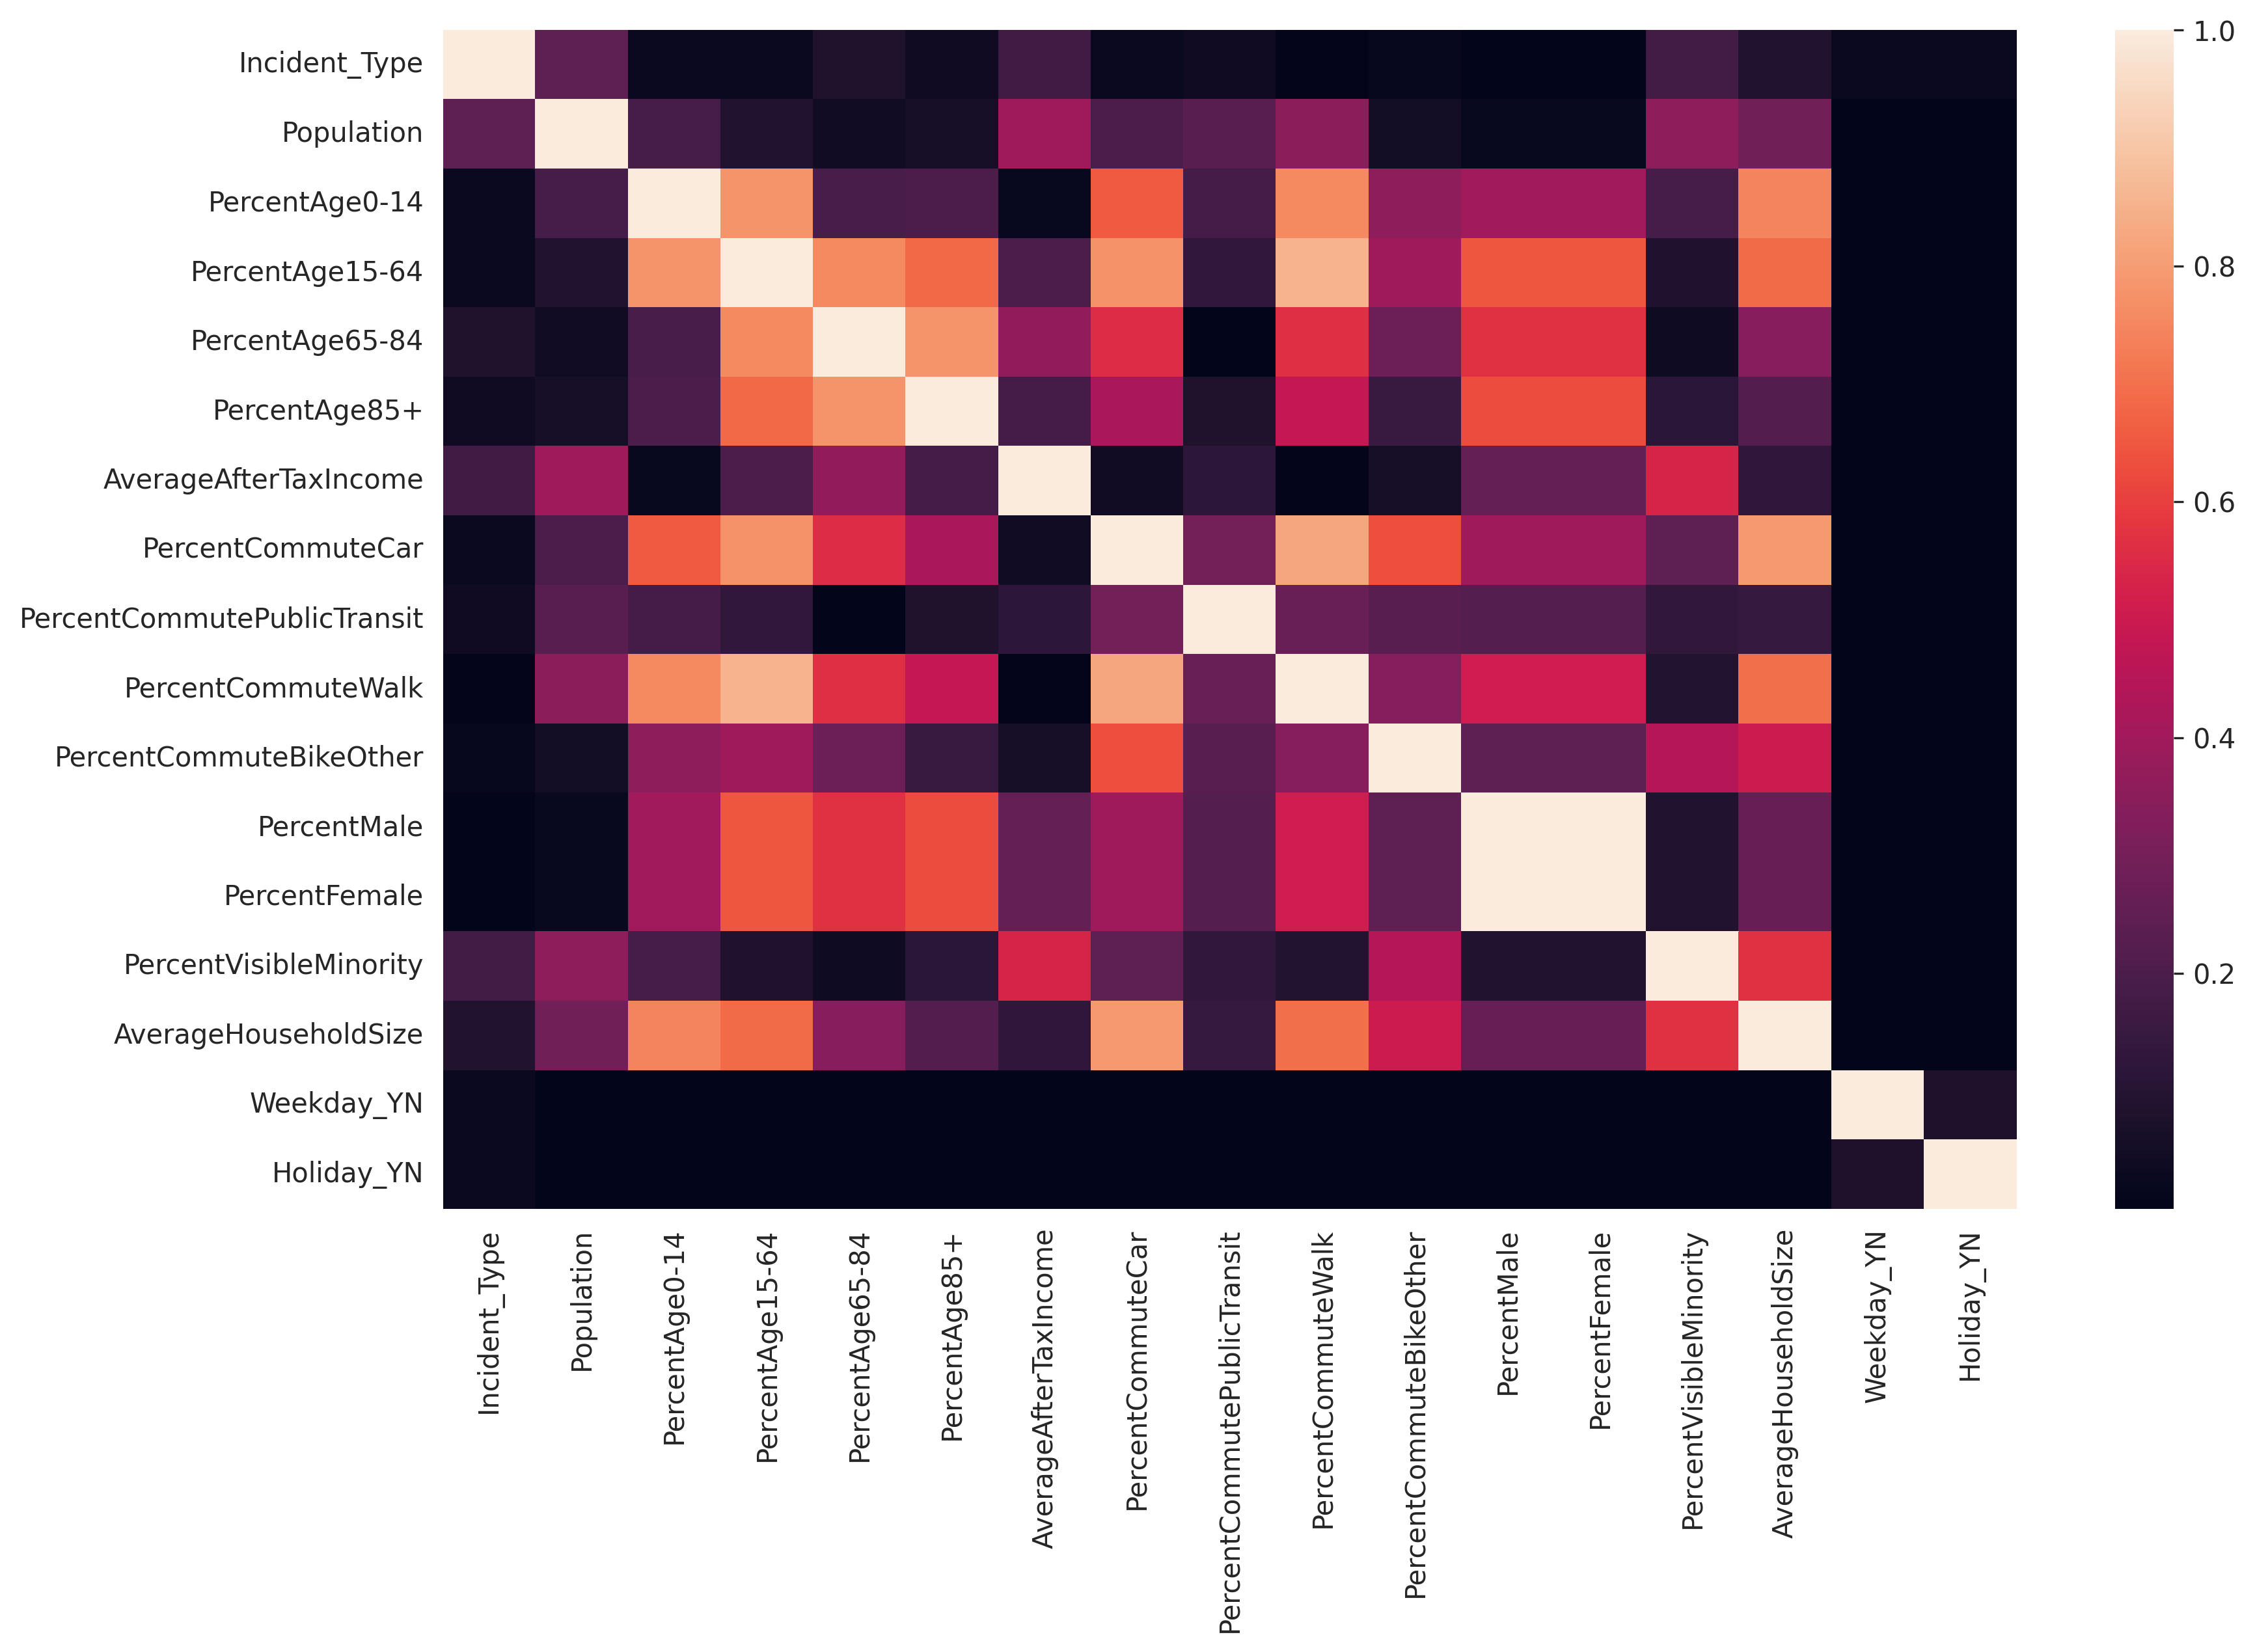

In [ ]:
#Exclude target column and binary covariates
corr_df = paramedicstatsdf.drop(columns=['Count_Calls']).corr().abs()
print(corr_df)  # Print correlation coefficents to notebook
plt.figure(figsize=(13,8),dpi=300)
# Plot correlation coefficents in heat map
sns.set_style('whitegrid')
sns.heatmap(corr_df)
plt.show()

In [ ]:
#Get centroids of FSAs

#1. Get shapefile from https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm and import it to QGIS
#2. Add centroid layer for each FSA
#3. Export layer as geojson and read here

centroiddf = gpd.read_file('https://drive.google.com/uc?id=1E5AaATgG8nOWIWnRmPi82VJatrfewzX6')
centroiddf.rename(columns={'CFSAUID':'FSA'},inplace=True)
centroiddf['CENTROID_LAT'] = centroiddf['geometry'].apply(lambda x: x.y)
centroiddf['CENTROID_LONG'] = centroiddf['geometry'].apply(lambda x: x.x)
centroiddf.drop(columns=['PRUID','PRNAME','geometry'],inplace=True)
centroiddf.sort_values(by='FSA',inplace=True)
centroiddf.head()

,FSA,CENTROID_LAT,CENTROID_LONG
20,M1B,43.818613,-79.191700
27,M1C,43.787542,-79.155065
21,M1E,43.766405,-79.185340
22,M1G,43.772458,-79.216698
28,M1H,43.766058,-79.238702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

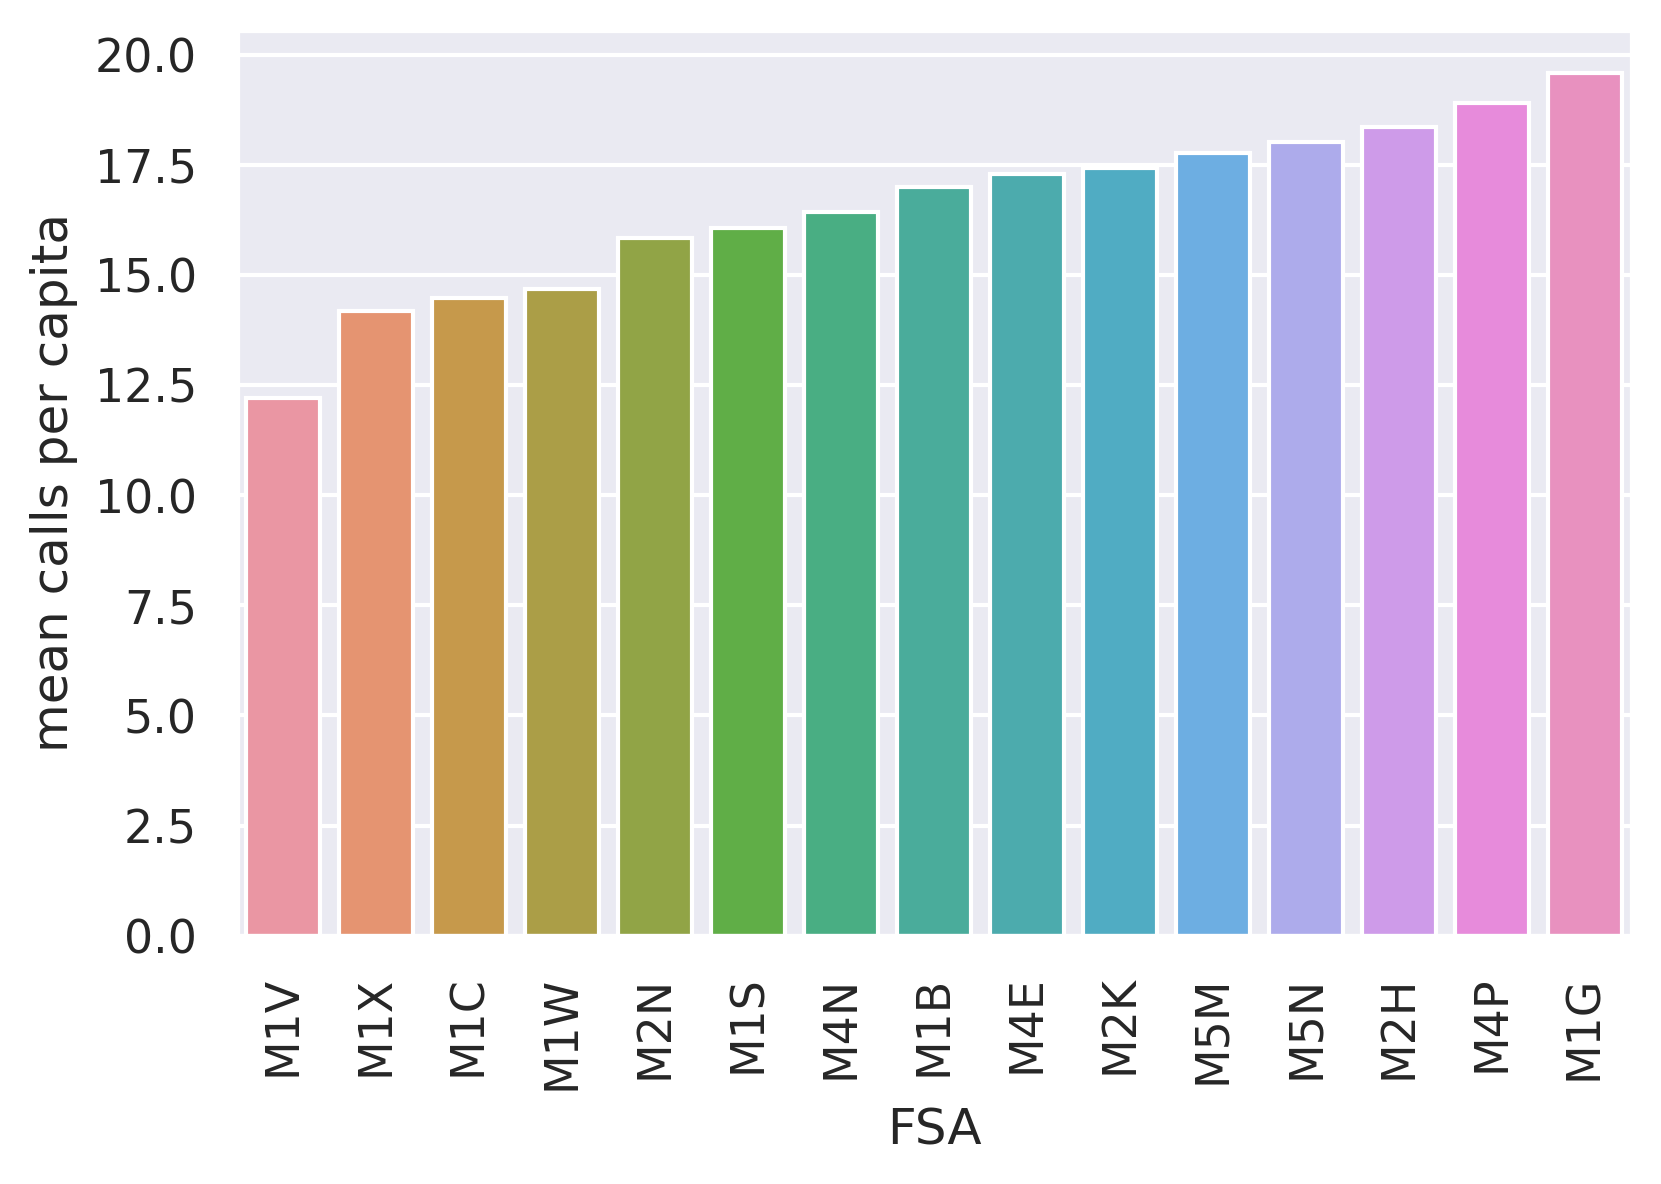

In [ ]:
eda_graph = paramedicstatsdf[['Forward_Sortation_Area','Count_Calls','Population']]

eda_graph['per_capita'] = eda_graph['Count_Calls'].div(eda_graph['Population'])*100000

eda_graph = eda_graph.groupby(['Forward_Sortation_Area'])['per_capita'].mean().reset_index()

eda_graph = eda_graph.sort_values(by=['per_capita']).reset_index(drop=True)

mpl.rcParams['figure.dpi'] = 300

sns.set_theme()

ax0 = sns.barplot(x="Forward_Sortation_Area",y="per_capita",data=eda_graph.iloc[:15])
ax0.set_xlabel('FSA')
ax0.set_ylabel('mean calls per capita')
plt.xticks(rotation=90)


# Linear, Ridge, and Lasso Regression Prediction Models

In [ ]:
# Import linear regression models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

# Import logistic regression models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#import train test split for model
from sklearn.model_selection import train_test_split
#Import standardizing library
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Define correlated function
def print_heavily_correlated_features(df, threshold=0.7):
  """
  For each feature in "df", this function counts the number of features that
  have a correlation coefficient with that is higher than "threshold".

  Parameters
  ----------
    df: pandas DataFrame type
        Contains the features for several data points
    threshold: float type
        he threshold for which "heavily correlated" is defined.
  """

  corr = df.corr().abs()  # calculate the correlation matrix
  corr = corr[corr > threshold]  # a mask of features that are heavily correlated

  # Print out the "heavily correlated" counts
  print(corr.count().sort_values(ascending=False) - 1)



In [ ]:

drop_for_x = ['Count_Calls', 'Forward_Sortation_Area', 'Dispatch_Time']


#Split by 30 percent (first 30 goes to test - limitation/assumption)
paramedicstatsdf = paramedicstatsdf.sort_values(by='Dispatch_Time').reset_index(drop=True)
index_to_split = int(paramedicstatsdf.shape[0]*0.3)
dfTest = paramedicstatsdf.loc[:index_to_split].reset_index(drop=True)
dfTrain = paramedicstatsdf.loc[index_to_split+1:].reset_index(drop=True)

X_train = dfTrain.drop(columns=drop_for_x)
y_train = dfTrain.Count_Calls

X_test = dfTest.drop(columns=drop_for_x)
y_test = dfTest.Count_Calls


print_heavily_correlated_features(X_train)

PercentAge15-64                4
PercentAge0-14                 3
PercentCommuteWalk             3
PercentCommuteCar              3
AverageHouseholdSize           2
PercentAge65-84                2
PercentAge85+                  1
PercentFemale                  1
PercentMale                    1
Holiday_YN                     0
Population                     0
PercentCommutePublicTransit    0
AverageAfterTaxIncome          0
Weekday_YN                     0
PercentCommuteBikeOther        0
PercentVisibleMinority         0
Incident_Type                  0
dtype: int64


In [ ]:
#DEBUG
print(X_train.size)
print(X_test.size)
print(y_train.size)
print(y_test.size)

411128
176205
24184
10365


In [ ]:
scoredf = pd.DataFrame(columns=['train_score','test_score'],index=['LinReg','LinRegMean','Ridge','RidgeMean','Lasso','LassoMean'])
scoredf

,train_score,test_score
LinReg,NaN,NaN
LinRegMean,NaN,NaN
Ridge,NaN,NaN
RidgeMean,NaN,NaN
Lasso,NaN,NaN
LassoMean,NaN,NaN


Simple linear Regression Model

In [ ]:
#Standardize features with large values (Population, income)

#Define training and testing set
#features to drop

#Only standardize certain features and standardize on the X_train data
columns_to_scale = ['Population','AverageAfterTaxIncome']
ct = ColumnTransformer([('norm1',StandardScaler(),columns_to_scale)],remainder='passthrough')
ct.fit(X_train)

X_train = pd.DataFrame(ct.transform(X_train), columns=np.append(columns_to_scale,[col for col in list(X_train.columns) if col not in columns_to_scale]))
X_test = pd.DataFrame(ct.transform(X_test),columns=np.append(columns_to_scale,[col for col in list(X_train.columns) if col not in columns_to_scale]))


In [ ]:
# define and fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict the number of calls per day
y_test_predictions = linreg.predict(X_test)

#score
train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)
print(f'The train score is {train_score:.3f} and the test score is {test_score:.3f}')

#Calculate Betas
linRegBetas = pd.Series(linreg.coef_, index=X_train.columns)
linRegBetas = linRegBetas.append(pd.Series({"Intercept": linreg.intercept_}))
print(linRegBetas)

scoredf.loc['LinReg',:] = [train_score,test_score]
scoredf.head()

The train score is 0.450 and the test score is 0.434
Population                       2.285373
AverageAfterTaxIncome           -0.402778
Incident_Type                    1.739263
PercentAge0-14                 216.916848
PercentAge15-64                212.720100
PercentAge65-84                199.665425
PercentAge85+                  273.606602
PercentCommuteCar              -27.605733
PercentCommutePublicTransit    -20.809146
PercentCommuteWalk             -20.029082
PercentCommuteBikeOther        -16.649673
PercentMale                     16.110878
PercentFemale                  -16.110878
PercentVisibleMinority           0.949060
AverageHouseholdSize            -0.992048
Weekday_YN                       0.006011
Holiday_YN                      -0.101214
Intercept                     -181.223649
dtype: float64


,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,NaN,NaN
Ridge,NaN,NaN
RidgeMean,NaN,NaN
Lasso,NaN,NaN


In [ ]:
#Use mean of all features to benchmark
X_mean_train = X_train.copy()
X_mean_test = X_test.copy()
X_mean_train['mean'] = X_mean_train.mean(axis=1)
X_mean_test['mean'] = X_mean_test.mean(axis=1)
linreg.fit(X_mean_train, y_train)
train_score = linreg.score(X_mean_train, y_train)
test_score = linreg.score(X_mean_test, y_test)

scoredf.loc['LinRegMean',:] = [train_score,test_score]
scoredf.head()

,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,0.449502,0.433677
Ridge,NaN,NaN
RidgeMean,NaN,NaN
Lasso,NaN,NaN


Ridge Regression Model

In [ ]:
# Fit the model
ridge = RidgeCV()
ridge.fit(X_train, y_train)

# calculate the score
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)
print(f'The train score is {train_score:.3} and the test score is {test_score:.3}')

# calculate betas
ridgeBetas = pd.Series(ridge.coef_, index=X_train.columns)
ridgeBetas = ridgeBetas.append(pd.Series({"Intercept": ridge.intercept_}))
print(ridgeBetas)

scoredf.loc['Ridge'] = [train_score,test_score]
scoredf.head()

The train score is 0.448 and the test score is 0.434
Population                      2.277057
AverageAfterTaxIncome          -0.401253
Incident_Type                   1.738778
PercentAge0-14                  0.370691
PercentAge15-64                -4.296445
PercentAge65-84               -16.823444
PercentAge85+                  49.536056
PercentCommuteCar              -6.846918
PercentCommutePublicTransit    -0.131002
PercentCommuteWalk              0.665936
PercentCommuteBikeOther         4.015666
PercentMale                    15.182118
PercentFemale                 -15.182118
PercentVisibleMinority          1.104229
AverageHouseholdSize           -1.084040
Weekday_YN                      0.005708
Holiday_YN                     -0.099224
Intercept                      15.227941
dtype: float64


,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,0.449502,0.433677
Ridge,0.448287,0.433854
RidgeMean,NaN,NaN
Lasso,NaN,NaN


In [ ]:
#Use mean of all features to benchmark
X_mean_train = X_train.copy()
X_mean_test = X_test.copy()
X_mean_train['mean'] = X_mean_train.mean(axis=1)
X_mean_test['mean'] = X_mean_test.mean(axis=1)
ridge.fit(X_mean_train, y_train)
train_score = ridge.score(X_mean_train, y_train)
test_score = ridge.score(X_mean_test, y_test)

scoredf.loc['RidgeMean',:] = [train_score,test_score]
scoredf.head()

,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,0.449502,0.433677
Ridge,0.448287,0.433854
RidgeMean,0.448288,0.433855
Lasso,NaN,NaN


Lasso Model

In [ ]:
# Fit the model
lasso = LassoCV()
lasso.fit(X_train, y_train)

# calculate the score
train_score = lasso.score(X_train, y_train)
test_score = lasso.score(X_test, y_test)
print(f'The train score is {train_score:.3} and the test score is {test_score:.3}')

# calculate betas
lassobetas = pd.Series(lasso.coef_, index=X_train.columns)
lassobetas = lassobetas.append(pd.Series({"Intercept": lasso.intercept_}))
print(lassobetas)

scoredf.loc['Lasso',:] = [train_score,test_score]
scoredf.head()

The train score is 0.441 and the test score is 0.431
Population                     2.240911e+00
AverageAfterTaxIncome         -6.370395e-01
Incident_Type                  1.744692e+00
PercentAge0-14                 0.000000e+00
PercentAge15-64                0.000000e+00
PercentAge65-84               -0.000000e+00
PercentAge85+                  0.000000e+00
PercentCommuteCar             -8.266866e+00
PercentCommutePublicTransit   -7.075845e-01
PercentCommuteWalk             1.722277e-01
PercentCommuteBikeOther        1.023616e+00
PercentMale                    1.061495e+01
PercentFemale                 -8.823736e-13
PercentVisibleMinority         0.000000e+00
AverageHouseholdSize          -5.921083e-01
Weekday_YN                     0.000000e+00
Holiday_YN                    -2.036204e-02
Intercept                      5.963229e+00
dtype: float64


,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,0.449502,0.433677
Ridge,0.448287,0.433854
RidgeMean,0.448288,0.433855
Lasso,0.441389,0.431382


In [ ]:
#Use mean of all features to benchmark
X_mean_train = X_train.copy()
X_mean_test = X_test.copy()
X_mean_train['mean'] = X_mean_train.mean(axis=1)
X_mean_test['mean'] = X_mean_test.mean(axis=1)
lasso.fit(X_mean_train, y_train)
train_score = lasso.score(X_mean_train, y_train)
test_score = lasso.score(X_mean_test, y_test)

scoredf.loc['LassoMean',:] = [train_score,test_score]
scoredf

,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,0.449502,0.433677
Ridge,0.448287,0.433854
RidgeMean,0.448288,0.433855
Lasso,0.441389,0.431382
LassoMean,0.441389,0.431382


# Feature Engineering

In [ ]:
#Feature Engineering
%%capture --no-stdout
# from sklearn.feature_selection import f_classif
# Create a list of F-values for the existing features
feature_F_scores, _ = f_classif(X_train, y_train)

# Iterate through each combination of features
for f1_index, f1 in enumerate(X_train.columns):
  for f2_index, f2 in enumerate(X_train.columns[f1_index + 1:]):
    # Multiply the two features to create a new feature
    new_feature = X_train[[f1]].multiply(X_train[f2], axis=0)
    # Evaluate F-value of new feature
    F_Score_new, p_value_new = f_classif(new_feature, y_train)
    # Evaluate the relative improvement of the new feature
    F_score_improvement = F_Score_new[0]/max(feature_F_scores[[f1_index, f2_index]])
    # Print out features that is sufficiently improved
    if F_score_improvement >= 1.0 and F_Score_new[0] >= 75 and p_value_new < 0.05:
        '''Note that F_score_improvement >= 1.5 and F_Score_new[0] >= 75 is
         relatively arbitrary, and that other values could be used.'''
        print(f'{f1} + {f2} has an F-score of {F_Score_new[0]:.2f}')
        print(f'\tBetter by a factor of {F_score_improvement:.2f} over features in isolation')
        print(f'\tThe result is significant (p = {p_value_new})')

Population + PercentAge0-14 has an F-score of 244.17
	Better by a factor of 1.14 over features in isolation
	The result is significant (p = [0.])
Population + PercentAge65-84 has an F-score of 226.75
	Better by a factor of 1.06 over features in isolation
	The result is significant (p = [0.])
Population + PercentCommuteCar has an F-score of 224.68
	Better by a factor of 1.05 over features in isolation
	The result is significant (p = [0.])
Population + PercentCommutePublicTransit has an F-score of 222.31
	Better by a factor of 1.03 over features in isolation
	The result is significant (p = [0.])
Population + PercentFemale has an F-score of 215.08
	Better by a factor of 1.00 over features in isolation
	The result is significant (p = [0.])
AverageAfterTaxIncome + PercentAge15-64 has an F-score of 129.39
	Better by a factor of 1.05 over features in isolation
	The result is significant (p = [0.])
AverageAfterTaxIncome + PercentMale has an F-score of 125.41
	Better by a factor of 1.02 over fe

Based on the feature engineering results we pick the 2 best feature combinations to improve model performance

In [ ]:
technique_name = 'Feature Engineering'

def new_feature_combos(X):
    """
    Make a new set of X data by doing algorithmic feature engineering
    """

    # First, we make a copy of the original X features
    X_new = X.copy()

    # Then we add new features
    X_new['Incident_Type * PercentCommutePublicTransit'] = X_new.Incident_Type * X_new.PercentCommutePublicTransit
    X_new['Incident_Type * PercentMale'] = X_new.Incident_Type * X_new.PercentMale
    X_new['Population * PercentAge0-14'] = X_new.Population * X_new['PercentAge0-14']
    X_new['Population * PercentAge65-84'] = X_new.Population * X_new['PercentAge65-84']
    X_new['Population * PercentCommuteCar'] = X_new.Population * X_new.PercentCommuteCar
    X_new['Population + PercentFemale'] = X_new.Population * X_new.PercentFemale
    X_new['AverageAfterTaxIncome * PercentAge15-64'] = X_new.AverageAfterTaxIncome * X_new['PercentAge15-64']
    X_new['AverageAfterTaxIncome * PercentMale'] = X_new.AverageAfterTaxIncome * X_new.PercentMale

    return X_new

# Make new X features with interactions
X_train_interactions = new_feature_combos(X_train)
X_test_interactions = new_feature_combos(X_test)

#fit the models
linreg.fit(X_train_interactions, y_train)
ridge.fit(X_train_interactions, y_train)
lasso.fit(X_train_interactions, y_train)
# Predict the number of calls per day using linear regression
y_test_predictions = linreg.predict(X_test_interactions)

#score feature engineered models
#linreg
train_score = linreg.score(X_train_interactions, y_train)
test_score = linreg.score(X_test_interactions, y_test)
scoredf.loc['LinRegFeatureEng',:] = [train_score,test_score]

#ridge
train_score2 = ridge.score(X_train_interactions, y_train)
test_score2 = ridge.score(X_test_interactions, y_test)
scoredf.loc['RidgeFeatureEng',:] = [train_score2,test_score2]
#lasso
train_score3 = lasso.score(X_train_interactions, y_train)
test_score3 = lasso.score(X_test_interactions, y_test)
scoredf.loc['LassoFeatureEng',:] = [train_score3,test_score3]

#print(f'lin reg test score = {test_score} and line reg train score = {train_score}')
scoredf

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1020.255677354522, tolerance: 45.265841370755375
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2658.5885916775733, tolerance: 45.265841370755375
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3812.2660739317653, tolerance: 45.265841370755375
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4517.20

,train_score,test_score
LinReg,0.449502,0.433677
LinRegMean,0.449502,0.433677
Ridge,0.448287,0.433854
RidgeMean,0.448288,0.433855
Lasso,0.441389,0.431382
LassoMean,0.441389,0.431382
LinRegFeatureEng,0.501754,0.487524
RidgeFeatureEng,0.500295,0.487584
LassoFeatureEng,0.477977,0.46661


# Feature Selection

In [ ]:
#Performs worse than doing the feature selection manually

# technique_name = 'Feature_Selection'

# # standardize the new features
# select_features = SelectKBest(f_classif, k='all')
# select_features = select_features.fit(X_train, y_train)

# # Get mask of columns that have good features
# feature_mask = select_features.get_support()
# X_train_feature_selection = X_train.iloc[:, feature_mask]
# X_test_feature_selection = X_test.iloc[:, feature_mask]

# # Fit and score the model

# linreg.fit(X_train_feature_selection, y_train)
# # Predict the number of calls per day
# y_test_predictions = linreg.predict(X_test_feature_selection)
# #scoring model
# train_score = linreg.score(X_train_feature_selection, y_train)
# test_score = linreg.score(X_test_feature_selection, y_test)
# print(f'lin reg test score = {test_score} and line reg train score = {train_score}')
# scoredf

# Optimization Model

In [ ]:
import cvxpy as cp

#paramedicstatscandf - contains merged call/demographic data
#centroiddf - contains centroid of each FSA data
#stationdf - contains ambulance station with long/lat data
#use standard linreg for prediction data as it scored best
stationdf.head()

,_id,ADDRESS_NUMBER,LINEAR_NAME_FULL,MUNICIPALITY,CITY,LONGITUDE,LATITUDE,FSA
0,47,900,Tapscott Rd,Scarborough,Toronto,-79.242870,43.823993,M1X
1,48,5700,Bathurst St,North York,Toronto,-79.444286,43.776286,M2R
2,49,4330,Dufferin St,North York,Toronto,-79.466532,43.761791,M3H
3,50,12,Canterbury Pl,North York,Toronto,-79.415355,43.772636,M2N
4,51,3100,Eglinton Ave E,Scarborough,Toronto,-79.226258,43.742000,M1J


we want to optimize to maximize the coverage of calls across the FSA's by positioning units to respond to our predicted calls which will be assumed to arrive at the centroid of an FSA.

We will use the standard linear regression with feature engineering to predict call volumes where each decision variable will be a discrete number of ambulance units to deploy in each xi station where we want to minimize the necessary number of ambulances in order to meet the predicted call demand for each station.

The constraints being that no single unit has to cover more than 25 calls as this would put too much strain on certain units and instead we should place more units in higher call volume areas.

We define boundaries of longitude and latitude reach for coverage that each unit will have which is 10km or about +/-0.09 longitude and latitude change where each call is allocated using a greedy algorithm to the nearest station within 10km.

In [ ]:
predicted_calls = pd.DataFrame(y_test_predictions, columns = ['Num_Calls'], index=y_test.index)
predicted_calls


,Num_Calls
0,11.783037
1,10.669733
2,5.705408
3,6.773717
4,6.491055
...,...
10360,15.897557
10361,3.642069
10362,10.662219
10363,14.455157


In [ ]:
#RECENT FIX: New logic ensures that predictions actually correspond to paramedicstatsdf data

#make dataframe that will assocate predictions to repsective FSAs and
predicted_calls = predicted_calls.join(paramedicstatsdf['Forward_Sortation_Area'])
predicted_calls = predicted_calls.join(paramedicstatsdf['Dispatch_Time'])
predicted_calls.rename(columns={'Forward_Sortation_Area':'FSA','Dispatch_Time':'date'},inplace=True)
#left join FSA with its assoicated centroid long and lat
predicted_calls = predicted_calls.merge(centroiddf, on='FSA', how='left')

#print(predicted_calls.loc[predicted_calls['date']=='2016-01-01'].shape[0])
#print(predicted_calls.loc[predicted_calls['date']=='2016-01-01']['Num_Calls'].sum())
predicted_calls.head()
#This predicted calls df will be used for the optimization model


,Num_Calls,FSA,date,CENTROID_LAT,CENTROID_LONG
0,11.783037,M1B,2016-01-01,43.818613,-79.191700
1,10.669733,M6E,2016-01-01,43.688624,-79.450653
2,5.705408,M6C,2016-01-01,43.691601,-79.431313
3,6.773717,M6B,2016-01-01,43.707993,-79.447412
4,6.491055,M6A,2016-01-01,43.722558,-79.450215


In [ ]:
#comparing sum predicted calls to sum real calls
# outputpredict = predicted_calls.copy()
# outputpredict = (outputpredict.drop(columns=['date','CENTROID_LAT','CENTROID_LONG']).groupby('FSA')['Num_Calls'].sum())
# outputpredict.to_csv('predicted_calls.csv')
# files.download('predicted_calls.csv')
print(predicted_calls.Num_Calls.sum())
print(paramedicstatsdf.loc[paramedicstatsdf['Dispatch_Time']<='2016-04-29']['Count_Calls'].sum())

79446.86263825226
83215


In [ ]:
#All of the days are included in the predicted dataset
# days_2016 = np.array(pd.date_range(start='2016-01-01',end='2016-12-31'))
# days_df = np.unique(predicted_calls['date'])
# print(np.setdiff1d(days_2016,days_df))

In [ ]:
#All of the FSAs are included in the predicted dataste
fsas_to = np.unique(paramedicstatsdf['Forward_Sortation_Area'])
fsas_df = np.unique(predicted_calls['FSA'])
print(np.setdiff1d(fsas_to,fsas_df))

[]


In [ ]:
import math
#Use haversine formula to calculate the distance between two points using the curvature of the Earth
def haversineformula(lon1,lat1,lon2,lat2):
  lon1,lat1,lon2,lat2 = map(math.radians, [lon1,lat1,lon2,lat2])

  a = math.sin((lat2-lat1)/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin((lon2-lon1)/2)**2
  c = math.asin(math.sqrt(a))*2
  _RADIUS_OF_EARTH = 6378
  return c * _RADIUS_OF_EARTH



In [ ]:
#NOTE: THIS WILL TAKE ONE MINUTE TO RUN (down from 43.57 minutes)


#predefine number of calls that will arrive within the coverage areas of each station assuming all calls arrive at FSA centroids
#This will return an integer amount of demand per station in which the optimization model will choose which stations to have or not


#focus on signle day predictions and optimization
#predicted_calls = predicted_calls[predicted_calls['date'] == '2016-01-01']

stationgreedy = pd.DataFrame(columns=['station_id','distance','demand','call_id','date'])

#generate demand based on number of calls if calls reside within 10km of a station
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2464671/ - reason for choosing 10km
max_distance = 10

#Keep track of which calls have been satisfied or not by tracing them

#Keep track of index to append each row (much more efficient than .append())
index_counter = 0

dictionary_data = {}

#Iterate through ambulance stations
for i, row1 in stationdf.iterrows():

  #Iterate through each call
  for j, row2 in predicted_calls.iterrows():

    #Use Euclidean distance to check distance between two points (because small distance)
    distance = haversineformula(row2['CENTROID_LONG'],row2['CENTROID_LAT'],row1['LONGITUDE'],row1['LATITUDE'])
    #If the coverage is manageable, add the corresponding number of calls to the demand

    #and temppredict['chosen_yn'].iloc[j] == 0.0
    if distance <= max_distance:
      #Add the station and the corresponding call
      dictionary_data[index_counter] = {'station_id':row1['_id'],'distance':distance,'demand':predicted_calls.Num_Calls.iloc[j],'call_id':j,'date':row2['date']}
      index_counter += 1
      #demand += temppredict.Num_Calls.iloc[j]
      #temppredict['chosen_yn'].iloc[j] = 1.0
  #tempstationdf['demand'].iloc[i] = demand
  #reset demand value
  #demand = 0

#Contains stationid with its distance and demand to a call with the corresponding date
stationgreedy = pd.DataFrame.from_dict(dictionary_data,'index')
print(stationgreedy)


        station_id  distance     demand  call_id       date
0               47  4.153179  11.783037        0 2016-01-01
1               47  9.720160  12.760765       52 2016-01-01
2               47  9.546458   6.555288       53 2016-01-01
3               47  1.007255   2.510388       54 2016-01-01
4               47  6.797847   7.383852       55 2016-01-01
...            ...       ...        ...      ...        ...
184160          92  6.908721   1.676699    10345 2016-04-19
184161          92  4.963083   8.352428    10346 2016-04-19
184162          92  7.632421   9.543448    10347 2016-04-19
184163          92  8.686910   6.619093    10356 2016-04-20
184164          92  9.662142   6.901755    10357 2016-04-20

[184165 rows x 5 columns]


In [ ]:
#NOTE: THIS WILL TAKE HALF A MINUTE TO RUN

#intialize demand and date columns
stationdf['demand'] = 0.0
stationdf['date'] = np.empty(stationdf.shape[0])
stationdf['date'] = pd.to_datetime(stationdf['date'],errors='coerce')

tempfinalstation = stationgreedy.copy()

list_of_dates = np.unique(predicted_calls['date'])

data_dict = {}
index_counter = 0

for date in list_of_dates[:-1]:
  #Greedy algorithm that allocates the demand to the minimum distance until the total demand is satisfied
  iterabledf = tempfinalstation.loc[tempfinalstation['date']==date]
  while not iterabledf.empty:

    for i, row in stationdf.iterrows():

      #Get dataframe with the above dataframe id equal to the individual station id
      stationiddf = iterabledf.loc[iterabledf['station_id']==row['_id']]

      #If ID is already satisfied, move on
      if stationiddf.empty:
        continue

      #Get the row from the resulting dataframe with the minimum amount of distance
      min_distance_row = stationiddf[stationiddf['distance'] == stationiddf['distance'].min()]

      #Add the demand closest to the station to the station demand
      data_dict[index_counter] = {'id':row['_id'],'FSA':row['FSA'],'demand':min_distance_row['demand'].iat[0],'date':date}

      #stationdf.at[i,'demand'] += min_distance_row['demand']
      #stationdf.at[i,'date'] = date
      #Remove every instance of that call demand as it has already been covered now by station i
      iterabledf = iterabledf[iterabledf['call_id'] != min_distance_row['call_id'].iat[0]].reset_index(drop=True)

      index_counter += 1


finalstationdf = pd.DataFrame.from_dict(data_dict,'index')
finalstationdf.head()


,id,FSA,demand,date
0,47,M1X,2.510388,2016-01-01
1,48,M2R,8.357549,2016-01-01
2,49,M3H,9.415410,2016-01-01
3,50,M2N,11.402996,2016-01-01
4,51,M1J,8.804538,2016-01-01


In [ ]:
#Accumulate demand
finalstationdf = finalstationdf.groupby(['id','FSA','date']).sum().reset_index()
finalstationdf.head()

,id,FSA,date,demand
0,47,M1X,2016-01-01,11.929208
1,47,M1X,2016-01-02,12.184447
2,47,M1X,2016-01-03,10.453093
3,47,M1X,2016-01-04,15.929824
4,47,M1X,2016-01-05,15.929824


Now that we have a dataframe that provides us the demand per station based on each units coverage of 10km, we can optimze to meet the demand each station will be covering.

In [ ]:
print(np.unique(finalstationdf['id']).shape[0])

46


In [ ]:
def optimization_model(stationdfarg):
  #deifning decision variables for how many units to place at each station to maximize coverage (meet demand)
  x = cp.Variable(stationdfarg.shape[0], integer = True)
  #assume each station can hold a maximum of 5 ambulance units where each unit can respond to 20 calls per day and there is a total of 242 units in toronto (from google)

  #define objective function - Ensure calls are coverage while minimizing total number of ambulances to deploy

  #Why we chose - first assume that ambulance can cover 25 calls. Under this assumption, we have enough ambulances to cover this number of calls - can't be infeasible
  #Necessary Limitation - assumes sequential calls and reasonable interarrival times to allow ambulances to respond appropriately
  obj = cp.Minimize(sum(x))


  #RELAXING CONSTRAINTS

  #define constraints
  cons = []
  cons.append(x <= 3) #maximum of 5 units per station
  cons.append(x >= 0) #nonnegativity
  cons.append(sum(x) <= 242)#total units available to deploy in Toronto

  for i, row in stationdfarg.iterrows():
    cons.append(x[i]*20 >= (stationdfarg.demand.iloc[i]))

  #solve the model
  prob = cp.Problem(obj,cons)
  prob.solve()

  prob.solve(verbose=False)
  return x



In [ ]:
#NOTE: THIS WILL TAKE AROUND 40 SECONDS TO RUN

#Iterate through optimization model for each day

#x_values = pd.DataFrame(columns=['station_id','FSA','no_ambulances'])

station_list = []
FSA_list = []
date_list = []
ambulance_list = []


#Input each date into model
for date in list_of_dates[:-1]:
  inputdf = finalstationdf.loc[finalstationdf['date']==date].reset_index(drop=True)

  x1 = optimization_model(inputdf)
  x_np_array = x1.value.astype(int)
  #data_dict[index_counter] = {'station_id':list(stationdf['_id']),'FSA':list(stationdf['FSA']),'no_ambulances':x_np_array,'date':np.repeat(date,stationdf['_id'].shape[0])}

  #station_list.append(list(stationdf['_id']))
  FSA_list.append(list(inputdf['FSA']))
  date_list.append(list(inputdf['date']))
  ambulance_list.append(x_np_array)

#Flatten out lists
#station_list = [i for sublist in station_list for i in sublist]
FSA_list = [i for sublist in FSA_list for i in sublist]
date_list = [i for sublist in date_list for i in sublist]
ambulance_list = [i for sublist in ambulance_list for i in sublist]


finalvalues = pd.DataFrame(list(zip(FSA_list,ambulance_list,date_list)),columns=['FSA','no_ambulances','date'])
finalvalues.head()

,FSA,no_ambulances,date
0,M1X,1,2016-01-01
1,M2R,1,2016-01-01
2,M3H,1,2016-01-01
3,M2N,2,2016-01-01
4,M1J,1,2016-01-01


In [ ]:
print(list_of_dates)

['2016-01-01T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2016-01-03T00:00:00.000000000' '2016-01-04T00:00:00.000000000'
 '2016-01-05T00:00:00.000000000' '2016-01-06T00:00:00.000000000'
 '2016-01-07T00:00:00.000000000' '2016-01-08T00:00:00.000000000'
 '2016-01-09T00:00:00.000000000' '2016-01-10T00:00:00.000000000'
 '2016-01-11T00:00:00.000000000' '2016-01-12T00:00:00.000000000'
 '2016-01-13T00:00:00.000000000' '2016-01-14T00:00:00.000000000'
 '2016-01-15T00:00:00.000000000' '2016-01-16T00:00:00.000000000'
 '2016-01-17T00:00:00.000000000' '2016-01-18T00:00:00.000000000'
 '2016-01-19T00:00:00.000000000' '2016-01-20T00:00:00.000000000'
 '2016-01-21T00:00:00.000000000' '2016-01-22T00:00:00.000000000'
 '2016-01-23T00:00:00.000000000' '2016-01-24T00:00:00.000000000'
 '2016-01-25T00:00:00.000000000' '2016-01-26T00:00:00.000000000'
 '2016-01-27T00:00:00.000000000' '2016-01-28T00:00:00.000000000'
 '2016-01-29T00:00:00.000000000' '2016-01-30T00:00:00.000000000'
 '2016-01-31T00:00:00.000

# Data Visualization & Results

The final dataframe containsthe station, FSA, the optimized minimal number of ambulances required at that station, and the day of the year in 2016 at which to do so.

The following analysis will focus on grouping by a particular feature and understanding how the rest of the dataset reacts:

1. Group by date, sum ambulances
2. Group by week, sum ambulances
3. Group by FSA, sum ambulances

          date  sum
0   2016-01-01   54
1   2016-01-02   54
2   2016-01-03   55
3   2016-01-04   56
4   2016-01-05   55
..         ...  ...
105 2016-04-15   56
106 2016-04-16   56
107 2016-04-17   56
108 2016-04-18   54
109 2016-04-19   55

[110 rows x 2 columns]


(array([735964., 735978., 735995., 736009., 736024., 736038., 736055.,
        736069.]), <a list of 8 Text major ticklabel objects>)

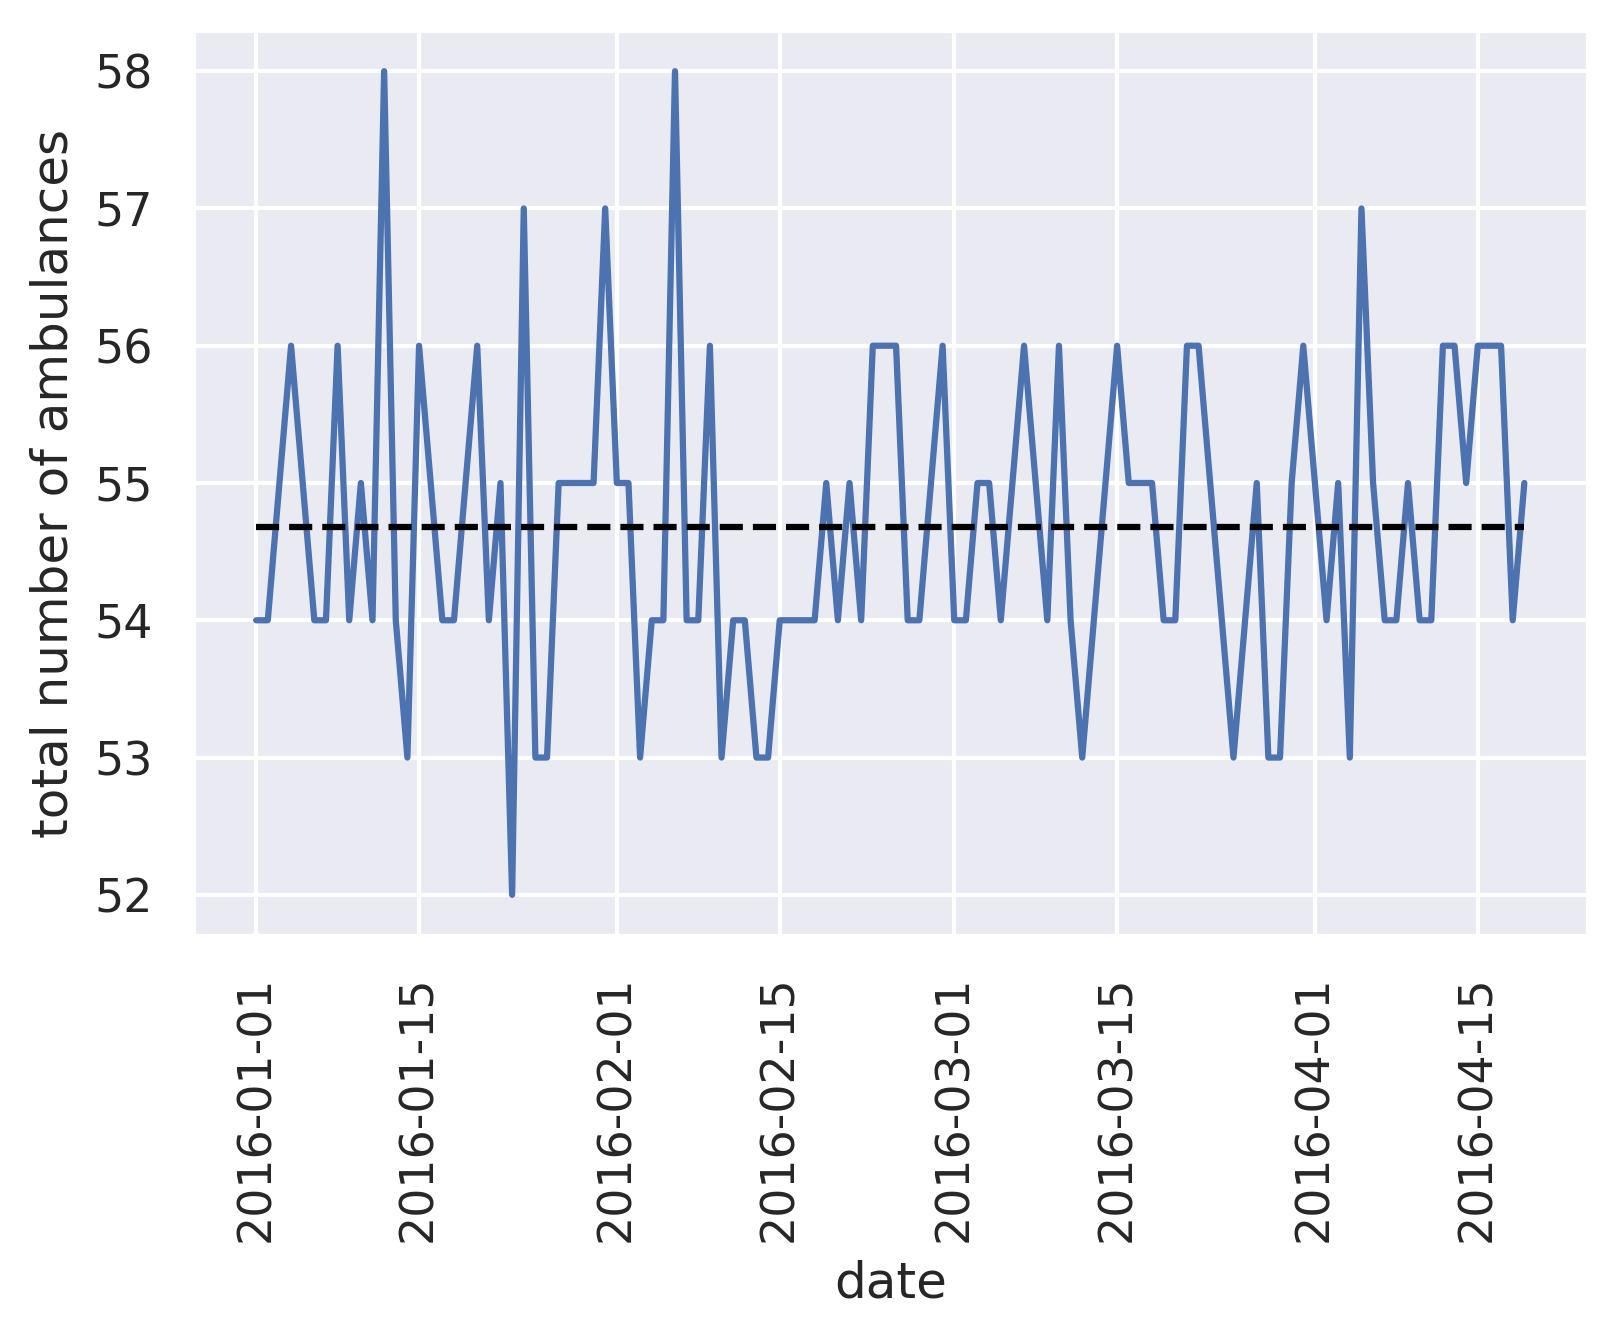

In [ ]:

sns.set_theme()
mpl.rcParams['figure.dpi'] = 300

dailycalls = finalvalues.groupby('date')['no_ambulances'].agg(['sum']).reset_index()
print(dailycalls)
#confidence_calculator(dailycalls)
ax1 = sns.lineplot(x='date',y='sum',data=dailycalls)
ax1 = sns.lineplot(x=dailycalls['date'],y=np.mean(dailycalls['sum']),linestyle='--',color='black')
#ax1.fill_between(dailycalls['date'],dailycalls['ci95_low'],dailycalls['ci95_high'],alpha=0.1)
ax1.set_ylabel('total number of ambulances')
#ax1.set_ylim([48.3,63.7])
plt.xticks(rotation=90)



In [ ]:
print(np.mean(dailycalls['sum']))

54.68181818181818


In [ ]:
print(np.unique(finalvalues['no_ambulances']))

[1 2]


In [ ]:
finalvalues.head()

,FSA,no_ambulances,date
0,M1X,1,2016-01-01
1,M2R,1,2016-01-01
2,M3H,1,2016-01-01
3,M2N,2,2016-01-01
4,M1J,1,2016-01-01


     week_no       date  no_ambulances
0          1 2016-01-04             56
1          1 2016-01-05             55
2          1 2016-01-06             54
3          1 2016-01-07             54
4          1 2016-01-08             56
..       ...        ...            ...
100       15 2016-04-13             56
101       15 2016-04-14             55
102       15 2016-04-15             56
103       15 2016-04-16             56
104       15 2016-04-17             56

[105 rows x 3 columns]


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 9 Text major ticklabel objects>)

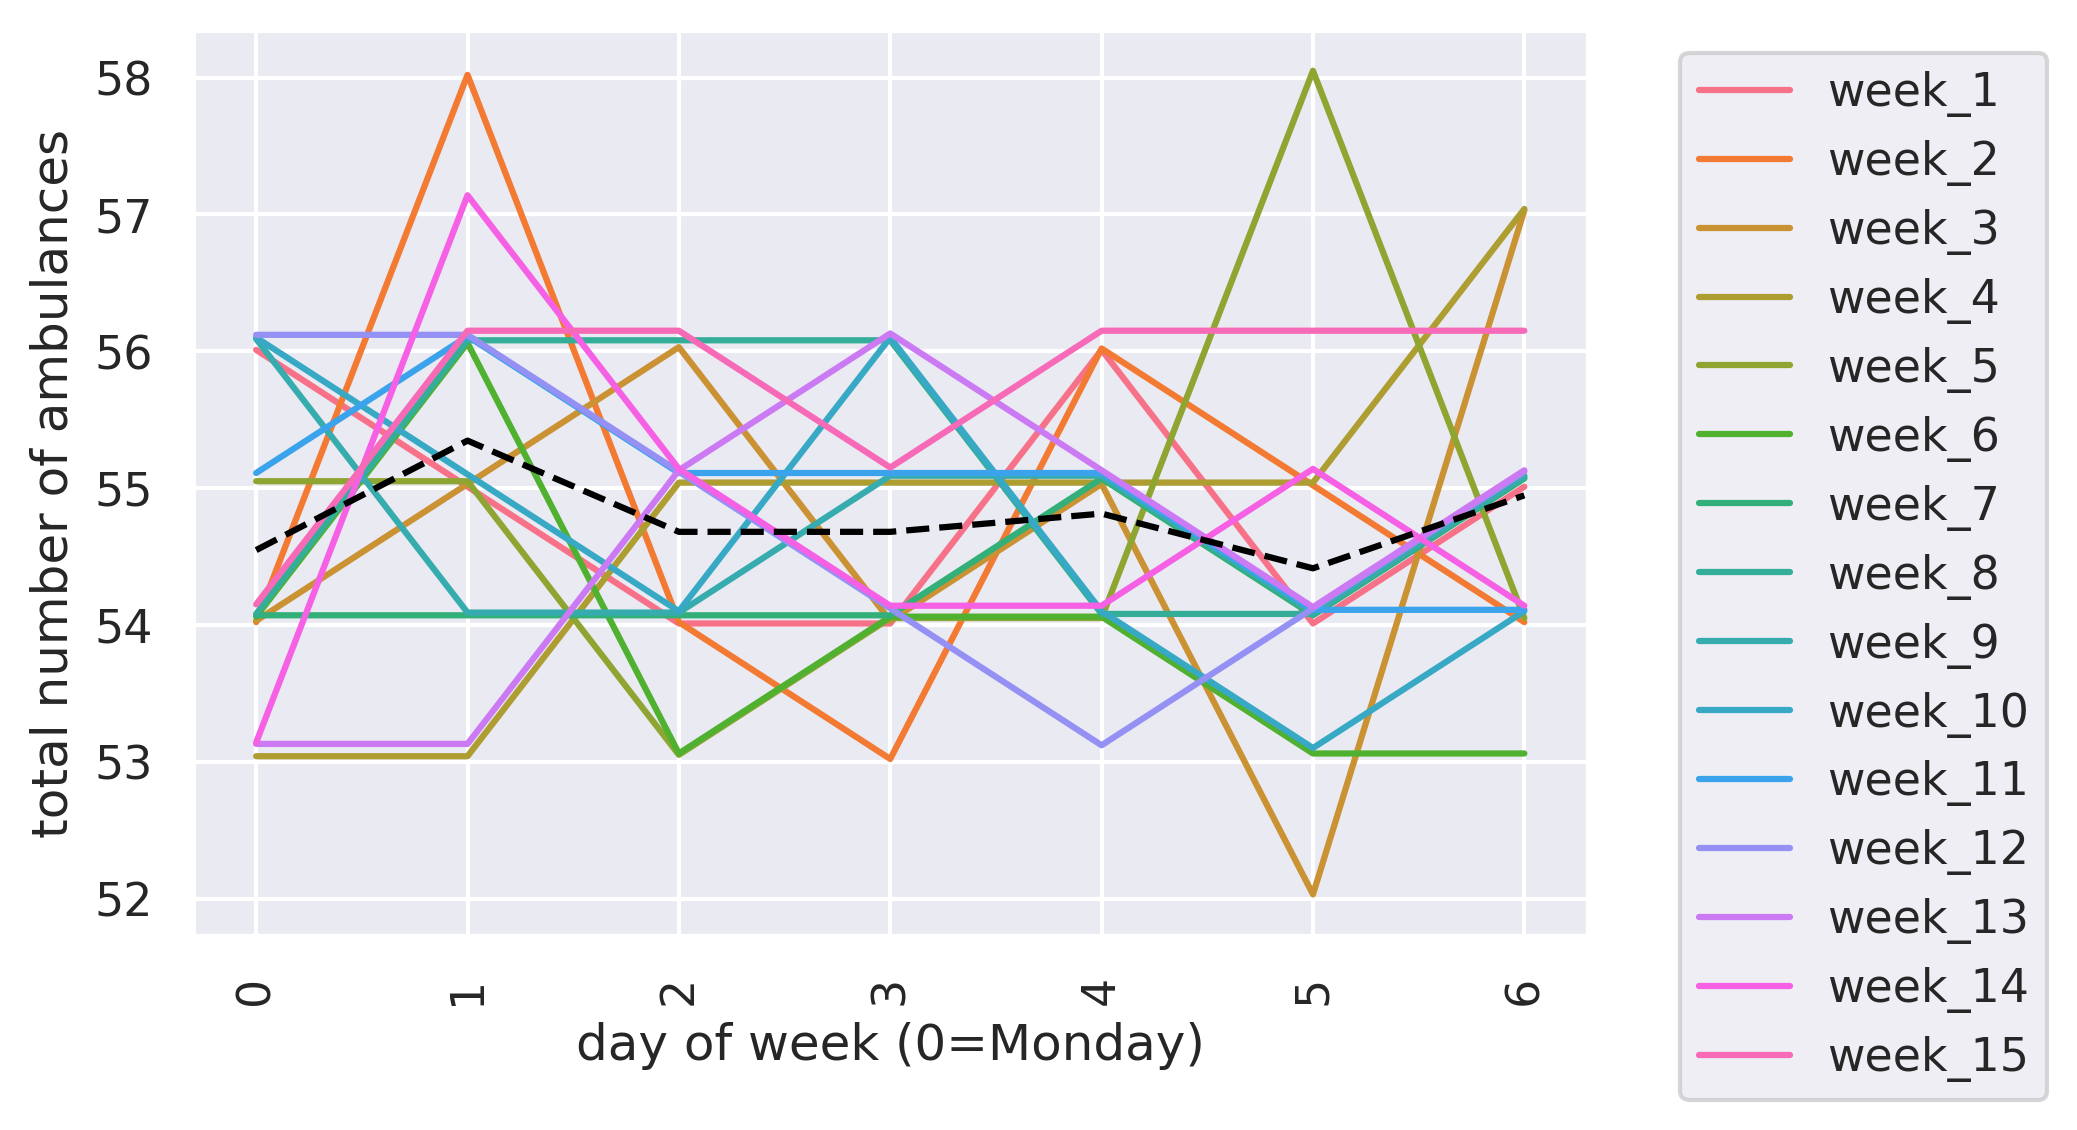

In [ ]:
finalvalues['week_no'] = finalvalues['date'].dt.isocalendar().week
weeklyvalues = finalvalues.copy()
#Remove first and last incomplete weeks
weeklyvalues = weeklyvalues[~weeklyvalues['week_no'].isin([53,16])].reset_index(drop=True)
weeklyvalues.drop(columns=['FSA'],inplace=True)
weeklyvalues = weeklyvalues.groupby(['week_no','date'])['no_ambulances'].sum().reset_index()
print(weeklyvalues)
#to deal with known seaborn bug
weeklyvalues['week_no'] = weeklyvalues['week_no'].apply(lambda x: 'week_'+str(x))
weeklyvalues['dayofweek'] = weeklyvalues['date'].dt.dayofweek
#to deal with overlapping lines
weeklyvalues['no_ambulances'] += weeklyvalues.apply(lambda x: int(x['week_no'].split('_')[1])/100,axis=1)
ax2 = sns.lineplot(x='dayofweek',y='no_ambulances',hue='week_no',data=weeklyvalues)
ax2 = sns.lineplot(x=weeklyvalues['dayofweek'],y=weeklyvalues.groupby('dayofweek')['no_ambulances'].mean(),linestyle='--',color='black')
ax2.set_ylabel('total number of ambulances')
ax2.set_xlabel('day of week (0=Monday)')
#ax2.set_ylim([48.3,63.7])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)
plt.xticks(rotation=90)

In [ ]:
#Done in QGIS


# fsamap = finalvalues.drop(columns='week_no').copy()
# #print(fsamap)
# fsamap = (fsamap.groupby(['FSA'])['no_ambulances'].sum()).reset_index()
# fsamap.rename(columns={'FSA':'CFSAUID'},inplace=True)
# fsamap.to_csv('fsamap.csv',index=False)
# files.download('fsamap.csv')

In [ ]:
#Add final checks to see FSA coverage

#Right join results with the original calls on the FSAs
# fsa_check = (x_values.merge(temppredict,on='FSA',how='right').sort_values(by='station_id').reset_index(drop=True))

# if (fsa_check.groupby('FSA').size()[0] == 1):
#   print('There is one instance of every FSA in the resulting dataframe')
# else:
#   raise ValueError('There are missing FSAs that were not accounted for in the call volumes')

# print('\nThere are',fsa_check.loc[fsa_check['no_ambulances'].isna(),['FSA']].shape[0],'FSAs with no ambulances. These FSAS are:\n',fsa_check.loc[fsa_check['no_ambulances'].isna(),'FSA'])

# print('\nAre all those FSAs with no ambulances also ones with no stations?:',[fsa for fsa in fsa_check['FSA'].tolist() if fsa not in stationdf['FSA'].tolist()] == fsa_check.loc[fsa_check['no_ambulances'].isna(),'FSA'].tolist())

#fsa_check.tail()